# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

from dqn_agent import Agent
from collections import deque
import torch
import matplotlib.pyplot as plt

Device: cuda:0


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
def reset_env(env, brain_name, train_mode, verbose = False):
    # reset the environment
    env_info = env.reset(train_mode=train_mode)[brain_name]
    
    if verbose:
        # number of agents in the environment
        print('Number of agents:', len(env_info.agents))

        # number of actions
        action_size = brain.vector_action_space_size
        print('Number of actions:', action_size)

        # examine the state space 
        state = env_info.vector_observations[0]
        print('States look like:', state)
        state_size = len(state)
        print('States have length:', state_size)

    return env_info

In [8]:
def get_data_from_env_info(env_info, verbose = False):
    state = env_info.vector_observations[0]
    reward = env_info.rewards[0]
    done = env_info.local_done[0]
    
    return state, reward, done

In [9]:
def run_dqn(agent, env, brain_name, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = reset_env(env, brain_name, train_mode=True)
        state, _0, _1 = get_data_from_env_info(env_info)
        score = 0
        
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state, reward, done = get_data_from_env_info(env_info)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

In [10]:
def plot_scores(scores):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

In [11]:
def watch_agent(filename, n_episodes = 5):
    # load the weights from file
    # load the weights from file
    agent = Agent(state_size=37, action_size=4, seed=190)
    agent.qnetwork_local.load_state_dict(torch.load(filename))

    for i in range(n_episodes):
        blue_bananas = 0
        yellow_bananas = 0
        episode_reward = 0
        
        env_info = env.reset(train_mode=False)[brain_name]
        state, reward, done = get_data_from_env_info(env_info)
        
        for j in range(200):
            action = agent.act(state)
            env_info = env.step(action)[brain_name]
            state, reward, done = get_data_from_env_info(env_info)
            if reward == 1:
                yellow_bananas += 1
                episode_reward += 1
            elif reward == -1:
                blue_bananas -= 1
                blue_bananas += 1
                
            if done:
                break
        print("Episode {0} summary: {1} yellow bananas, {2} blue bananas. Score: {3}".format(i+1, yellow_bananas, blue_bananas, episode_reward))

In [12]:
agent = Agent(state_size=37, action_size=4, seed=190)
scores = run_dqn(agent, env, brain_name)

Episode 100	Average Score: 0.94
Episode 200	Average Score: 3.60
Episode 300	Average Score: 6.52
Episode 400	Average Score: 9.88
Episode 500	Average Score: 12.00
Episode 600	Average Score: 12.98
Episode 601	Average Score: 13.00
Environment solved in 501 episodes!	Average Score: 13.00


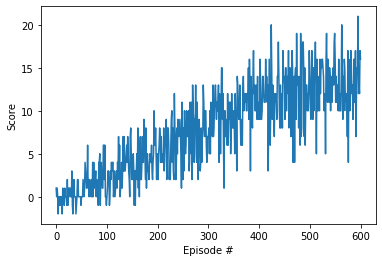

In [13]:
plot_scores(scores)

In [14]:
watch_agent('checkpoint.pth')

Episode 1 summary: 6 yellow bananas, 0 blue bananas. Score: 6
Episode 2 summary: 5 yellow bananas, 0 blue bananas. Score: 5
Episode 3 summary: 12 yellow bananas, 0 blue bananas. Score: 12
Episode 4 summary: 0 yellow bananas, 0 blue bananas. Score: 0
Episode 5 summary: 10 yellow bananas, 0 blue bananas. Score: 10


In [15]:
env.close()

## Future ideas for improving performance

For better results, there are some strategies we can try:
- Simply let model train for more episodes, without stopping when we achieve our goal average score;
- Add more nodes to our current hidden layers;
- Add more hidden layers to our fully connected architecture;
- Change our architecture — maybe we can try something like an LSTM network;
- Fine tune an existing network that are already trained;
- Optimize our hyperparameters such as batch size, gamma, learning rate